<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-Detectron2/blob/main/Chapter11/Detectron2_Chapter11_PointRend_Custom.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 11 - Train Custom PointRend Model

## Dataset

In [ ]:
!wget -q https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-Detectron2/raw/main/datasets/segbraintumors_coco.zip
!unzip -q segbraintumors_coco.zip

## Installation

In [ ]:
!python -m pip --quiet install \
'git+https://github.com/facebookresearch/detectron2.git'

## Register datasets

In [ ]:
from detectron2.utils.logger import setup_logger
logger = setup_logger()
from detectron2.data.datasets import register_coco_instances
# Suppress some user warnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
# Some configurations
name_ds = "segbraintumors_coco"
name_ds_train = name_ds + "_train"
name_ds_test = name_ds + "_test"
image_root_train = name_ds + "/train"
image_root_test = name_ds + "/test"
af = "_annotations.coco.json"
json_file_train = name_ds + "/train/" + af
json_file_test = name_ds + "/test/" + af

# Register datasets
## train dataset
register_coco_instances(
    name = name_ds_train,
    metadata = {},
    json_file = json_file_train,
    image_root = image_root_train
    )
## test dataset
register_coco_instances(
    name = name_ds_test,
    metadata = {},
    json_file = json_file_test,
    image_root = image_root_test
    )


### Clone Repo for the project


In [ ]:
# clone the repo in order to access pre-defined configs in PointRend project
!git clone https://github.com/facebookresearch/detectron2.git detectron2_repo

Cloning into 'detectron2'...
remote: Enumerating objects: 14778, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 14778 (delta 18), reused 38 (delta 12), pack-reused 14721
Receiving objects: 100% (14778/14778), 6.04 MiB | 2.53 MiB/s, done.
Resolving deltas: 100% (10689/10689), done.


## Training configuration

In [ ]:
import os
import torch
from detectron2.config import get_cfg
from detectron2 import model_zoo
import pickle

output_dir = "output/pointrend"
os.makedirs(output_dir, exist_ok=True)
output_cfg_path = os.path.join(output_dir, "cfg.pickle")
nc = 3
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# import PointRend project
from detectron2.projects import point_rend
# Select a lighter model to train faster
config_file = "detectron2_repo/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco.yaml"
checkpoint_file = "detectron2://PointRend/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco/164955410/model_final_edd263.pkl"
# Create a configuration file
cfg = get_cfg()
# Add PointRend-specific config
point_rend.add_pointrend_config(cfg)
cfg.merge_from_file(config_file)
# Download weights
cfg.MODEL.WEIGHTS = checkpoint_file

# Set datasets
cfg.DATASETS.TRAIN = (name_ds_train,)
cfg.DATASETS.TEST = (name_ds_test,)
# Workers
cfg.DATALOADER.NUM_WORKERS = 2
# Solver
cfg.SOLVER.IMS_PER_BATCH = 6
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.STEPS = (3000, 4000)
cfg.SOLVER.GAMMA = 0.5
cfg.SOLVER.NESTROV = False
cfg.SOLVER.MAX_ITER = 5000
# checkpoint
cfg.SOLVER.CHECKPOINT_PERIOD = 500
# anchors
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[68.33245953, 112.91302277,  89.55701886, 144.71037342,  47.77637482]]
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.99819939, 0.78726896, 1.23598428]]
# pixels
cfg.MODEL.PIXEL_MEAN = [20.1962, 20.1962, 20.1962]
cfg.MODEL.PIXEL_STD = [39.5985, 39.5985, 39.5985]
# Evaluation
cfg.TEST.EVAL_PERIOD = cfg.SOLVER.CHECKPOINT_PERIOD

# Classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = nc
cfg.MODEL.DEVICE = device
cfg.OUTPUT_DIR = output_dir

# New
cfg.MODEL.POINT_HEAD.NUM_CLASSES = nc

In [ ]:
# save configuration file for future use
with open(output_cfg_path, "wb") as f:
  pickle.dump(cfg, f, protocol = pickle.HIGHEST_PROTOCOL)

## Training

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.data import build_detection_train_loader

class BrainTumorTrainer(DefaultTrainer):
  """
  This trainer evaluate data on the `cfg.DATASETS.TEST` validation dataset every `cfg.TEST.EVAL_PERIOD` iterations.
  """
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    if output_folder == None:
      output_folder = cfg.OUTPUT_DIR
    else:
      output_folder = os.path.join(cfg.OUTPUT_DIR, output_folder)
      os.makedirs(output_folder)
    # Use 
    return COCOEvaluator(dataset_name, distributed=False, output_dir=output_folder)


In [ ]:
from detectron2.engine.hooks import HookBase
import torch
import logging

class BestModelHook(HookBase):
  def __init__(self, cfg, 
               metric   = "segm/AP50", 
               min_max  = "max"):
    self._period = cfg.TEST.EVAL_PERIOD
    self.metric = metric
    self.min_max = min_max
    self.best_value = float("-inf") if min_max == "max" else float("inf")
    logger = logging.getLogger("detectron2")
    logger.setLevel(logging.DEBUG)
    logger.propagate = False
    self._logger = logger
        

  def _take_latest_metrics(self):
    with torch.no_grad():
      latest_metrics = self.trainer.storage.latest()
      return latest_metrics
      
  def after_step(self):
    next_iter = self.trainer.iter + 1
    is_final = next_iter == self.trainer.max_iter
    if is_final or (self._period > 0 and next_iter % self._period == 0):
      latest_metrics = self._take_latest_metrics()
      for (key, (value, iter)) in latest_metrics.items():
        if key == self.metric:
          if (self.min_max == "min" and value < self.best_value) or (self.min_max == "max" and value > self.best_value):
            self._logger.info("Updating best model at iteration {} with {} = {}".format(iter, self.metric, value))
            self.best_value = value
            self.trainer.checkpointer.save("model_best")
            

In [ ]:
trainer = BrainTumorTrainer(cfg)
bm_hook = BestModelHook(cfg, 
                        metric  = "segm/AP50", 
                        min_max = "max")
trainer.register_hooks(hooks=[bm_hook])


[01/28 15:20:16 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [ ]:
import torch
from detectron2.layers import cat
from detectron2.structures import Boxes
from detectron2.projects.point_rend.point_features import(
    get_point_coords_wrt_image,
    sample_point_labels,
    get_uncertain_point_coords_with_randomness
)
from detectron2.projects.point_rend.mask_head import (
    calculate_uncertainty
)

In [ ]:
def _sample_train_points(self, coarse_mask, instances):
  assert self.training
  gt_classes = cat([x.gt_classes for x in instances])
  with torch.no_grad():
    # Step 1: sample point coordinates (point_coords)
    point_coords=get_uncertain_point_coords_with_randomness(
      coarse_mask,
      lambda logits: calculate_uncertainty(
          logits, 
          gt_classes),
      self.mask_point_train_num_points,
      self.mask_point_oversample_ratio,
      self.mask_point_importance_sample_ratio,
    )
    # Step 2: get point_coords with respect to the image
    proposal_boxes = [x.proposal_boxes for x in instances]
    cat_boxes = Boxes.cat(proposal_boxes)
    point_coords_wrt_image = get_point_coords_wrt_image(
        cat_boxes.tensor, 
        point_coords)
    # Step 3: generate labels for the sampled points
    sR, sP, s2 = point_coords.shape
    assert s2 == 2, point_coords.shape
    point_labels = torch.zeros( size	  = (sR, sP), 
                                dtype  = point_coords.dtype, 
                                layout = point_coords.layout, 
                                device = point_coords.device)
    try:
      point_labels = sample_point_labels(
          instances, 
          point_coords_wrt_image)
    except:
      print("**************empty instances**************")
    
  return point_coords, point_labels

In [ ]:
import types
mask_head = trainer.model.roi_heads.mask_head
mask_head._sample_train_points = types.MethodType(
    _sample_train_points,
    mask_head
)

In [ ]:
trainer.train()

[01/28 15:20:20 d2.engine.train_loop]: Starting training from iteration 0
[01/28 15:20:35 d2.utils.events]:  eta: 0:52:25  iter: 19  total_loss: 3.205  loss_cls: 0.1529  loss_box_reg: 0.007521  loss_mask: 0.6686  loss_mask_point: 0.6867  loss_rpn_cls: 0.8011  loss_rpn_loc: 0.9967  time: 0.6308  data_time: 0.0952  lr: 1.9981e-05  max_mem: 5314M
[01/28 15:20:48 d2.utils.events]:  eta: 0:52:19  iter: 39  total_loss: 2.543  loss_cls: 0.1411  loss_box_reg: 0.01078  loss_mask: 0.5867  loss_mask_point: 0.6925  loss_rpn_cls: 0.6876  loss_rpn_loc: 0.3741  time: 0.6324  data_time: 0.0823  lr: 3.9961e-05  max_mem: 5314M
[01/28 15:21:01 d2.utils.events]:  eta: 0:52:22  iter: 59  total_loss: 2.284  loss_cls: 0.1118  loss_box_reg: 0.01161  loss_mask: 0.5473  loss_mask_point: 0.6998  loss_rpn_cls: 0.6662  loss_rpn_loc: 0.2398  time: 0.6378  data_time: 0.0782  lr: 5.9941e-05  max_mem: 5314M
[01/28 15:21:15 d2.utils.events]:  eta: 0:53:30  iter: 79  total_loss: 2.218  loss_cls: 0.08034  loss_box_reg: 0

## Draw Some Samples

In [ ]:
from detectron2.engine import DefaultPredictor
# best model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST  = 0.6
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 
                                 "model_best.pth")
predictor = DefaultPredictor(cfg)

[01/28 16:25:02 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                            | Names in Checkpoint                                                                                  | Shapes                                          |
|:----------------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*                         | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*                         | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*                  

In [ ]:
import random
random.seed(42)
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import matplotlib.pyplot as plt

def plot_samples(samples, 
                 met        = {}, 
                 is_gt      = True, 
                 predictor  = None):
  n = len(samples)
  nrows = int(-(-n/3)) # ceil
  ncols = 3
  fig, axs = plt.subplots(nrows   = nrows, 
                          ncols   = ncols, 
                          figsize = (21, 7))
  for i,s in enumerate(samples):
    row = i//ncols
    col = i%ncols
    ax = axs[row][col] if len(axs.shape)==2 else axs[i]
    img = cv2.imread(s["file_name"])
    v = Visualizer(img[:,:, ::-1], metadata=met, scale=0.5)
    if is_gt:
      # visualize ground-truths
      v = v.draw_dataset_dict(s)
    else:
      # predict
      outputs = predictor(img)
      # visualize prediction results
      instances = outputs["instances"].to("cpu")
      v = v.draw_instance_predictions(instances)

    ax.imshow(v.get_image())
    ax.axis("off")
  plt.tight_layout()
  plt.show()

def plot_random_samples(name_ds, n=3, predictor=None):
  # access
  ds = DatasetCatalog.get(name_ds)
  met = MetadataCatalog.get(name_ds)
  samples = random.sample(ds, n)
  # plot samples with ground-truths
  plot_samples(samples, met)
  # plot predictions
  plot_samples(samples, 
               met        = met, 
               predictor  = predictor, 
               is_gt      = False)

[01/28 16:27:15 d2.data.datasets.coco]: Loaded 307 images in COCO format from segbraintumors_coco/test/_annotations.coco.json


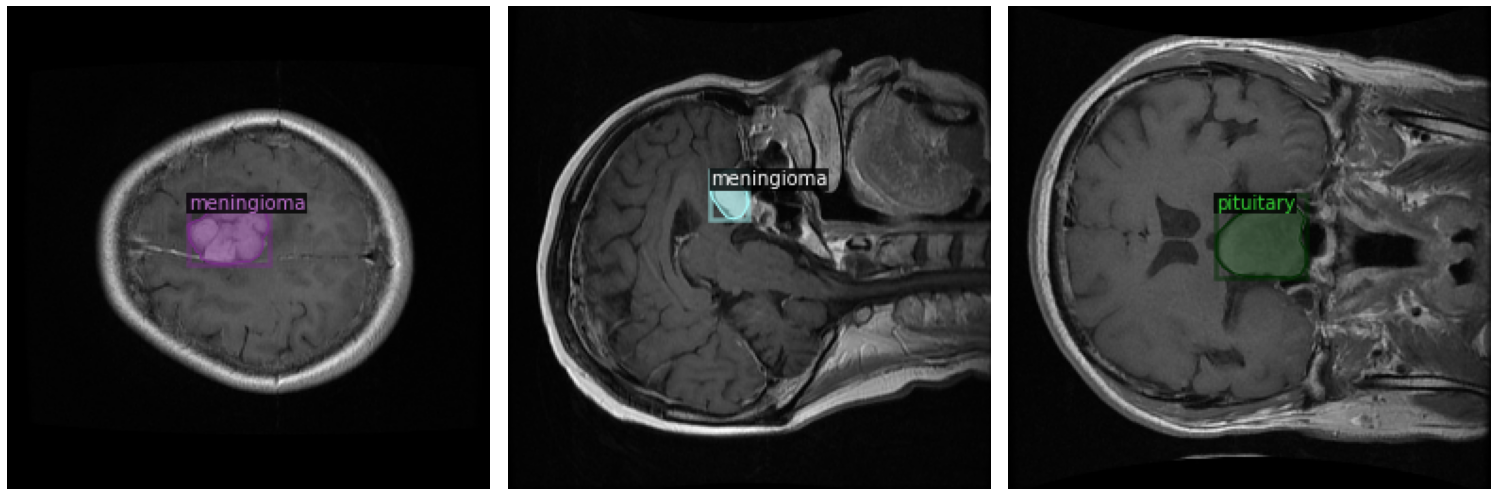

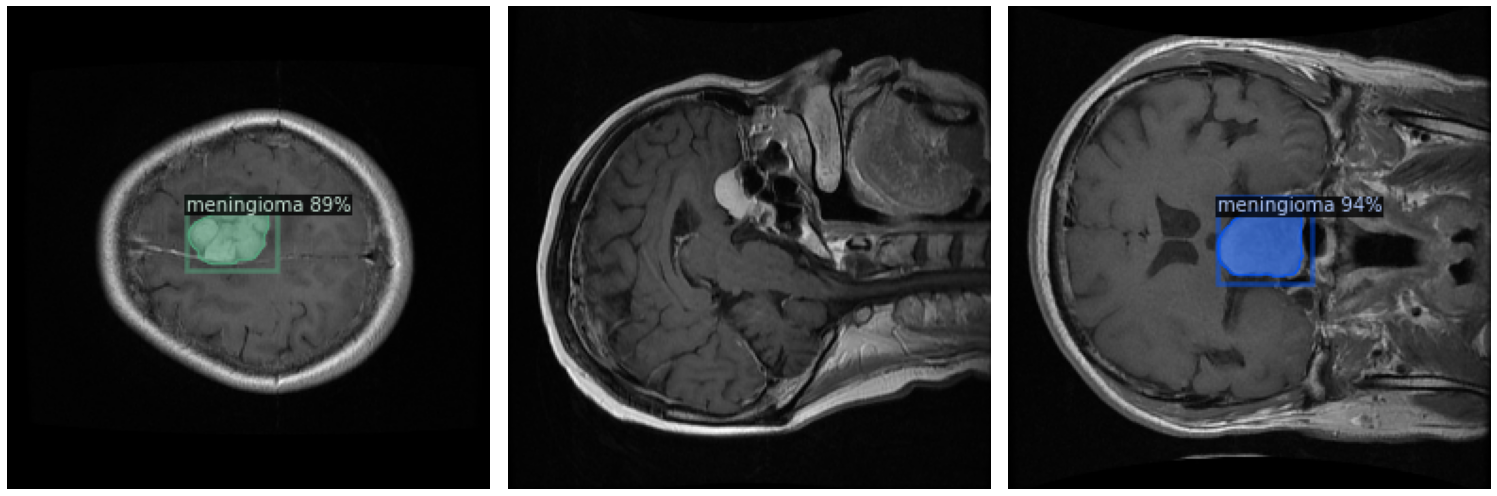

In [ ]:
plot_random_samples(name_ds_test, predictor = predictor)